In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from utils import constants as cnst, u_darrays as uda
import salem
import xarray as xr
# Some defaults
cmap = plt.get_cmap('RdBu_r')
sns.set_context('talk')
sns.set_style('ticks')

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [262]:
#mcs = cnst.GRIDSAT_PERU + 'aggs/gridsat_WA_-40_allClouds_monthly.nc'
mcs = cnst.GRIDSAT_PERU + 'aggs/gridsat_WA_count_-30_allClouds_monthly.nc'
chirps = '/media/ck/Elements/SouthAmerica/CHIRPS/chirps-v2.0.monthly.nc'

fpath = cnst.network_data + 'figs/HUARAZ/'

fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
isbuffer = [-79, -74, -12, -7]

sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)

da3 = xr.open_dataarray(mcs).sel(lon=slice(isbuffer[0], isbuffer[1]), lat=slice(isbuffer[2], isbuffer[3]))
ca = xr.open_dataarray(chirps).sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))
# This masks out the data which is not in the region

da3 = da3.salem.roi(shape=sdf).mean(['lat', 'lon'])*100
ca = ca.salem.roi(shape=sdf).mean(['latitude', 'longitude'])

In [282]:
gts = da3.sel(time=((da3['time.month']>=11) | (da3['time.month']<=3))).groupby('time.year').mean('time')
cts = ca.sel(time=((ca['time.month']>=11) | (ca['time.month']<=3))).groupby('time.year').mean('time')

In [301]:
def readERA():

    u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/u_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [302]:
era = readERA()
era = era.sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))

In [303]:
era_valley = era['u'].salem.roi(shape=sdf).mean(['latitude', 'longitude']) #salem.roi(shape=sdf)
ets = era_valley.sel(time=((era_valley['time.month']==1) | (era_valley['time.month']<=3))).groupby('time.year').mean('time')

In [286]:
posgrid = np.intersect1d(ets.year.values, gts.year.values)

gsat = gts.sel(year=posgrid)
ets = ets.sel(year=posgrid)

posgrid = np.intersect1d(ets.year.values, cts.year.values)
cts = cts.sel(year=posgrid)

In [287]:
ets = ets.to_pandas()
gts = gts.to_pandas()
cts = cts.to_pandas()

In [288]:
ets.index

Int64Index([1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
            1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
            2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
           dtype='int64', name='year')

Int64Index([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
            2006, 2007, 2008, 2009, 2010, 2011, 2012],
           dtype='int64', name='year') LinregressResult(slope=-0.3664955404006177, intercept=15.505902921772142, rvalue=-0.2320372287320378, pvalue=0.3541814403168544, stderr=0.38409002837622325)


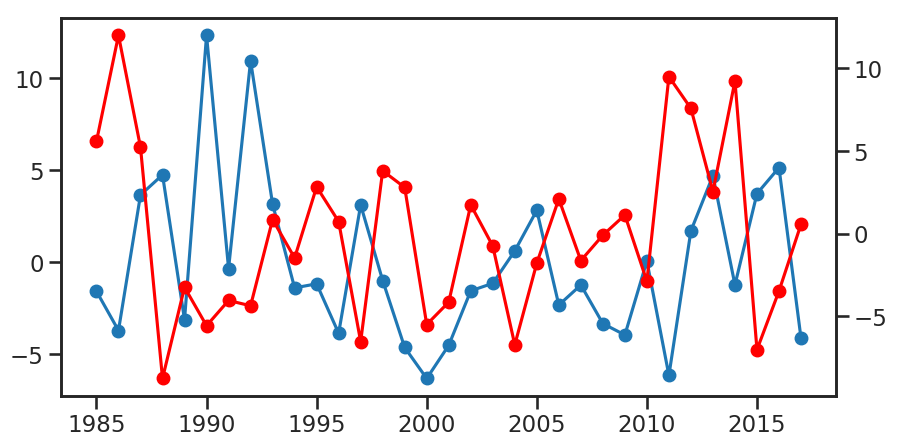

In [289]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
ax.plot(ets-np.mean(ets), marker='o')
ax1 = ax.twinx()
ax1.plot(gts-np.mean(gts), color='r', marker='o')
print(ets.index[10:-5],stats.linregress(ets.values[10:-5], gts.values[10:-5]))

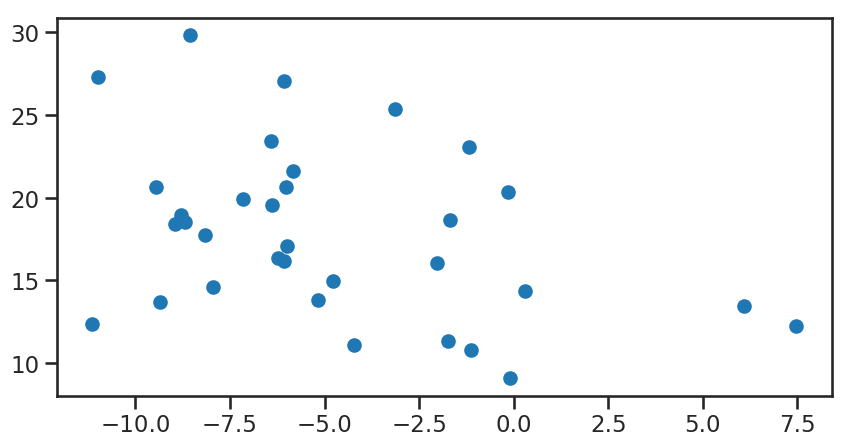

In [290]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
plt.scatter(ets,gts)

### Trend analysis 

In [291]:
# the trend are computed on time series at least 20yrs long
start_years = ets.index[:-5]
end_years = ets.index[5:]
ny = len(start_years)
extent = (start_years[0], start_years[-1], end_years[0], end_years[-1])  # needed for the plot later

In [292]:
# fill the triangle
trend = np.zeros((ny, ny)) * np.NaN
sig = np.ones((ny, ny)) 
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data1 = ets.loc[start_year:end_year]
        data2 = cts.loc[start_year:end_year]
        if len(data1) < 5:
            continue
        slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
        trend[j, i] = r   # for decadal trends
        sig[j, i] = p_val

### Plot 

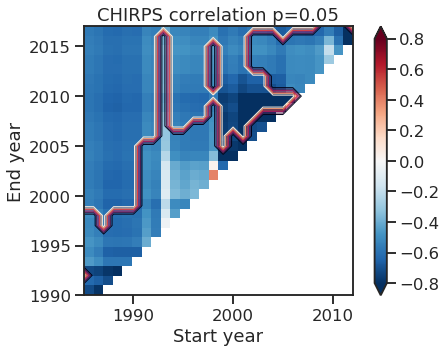

In [293]:
# plot
plt.figure(figsize=(7, 5))
im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.8, vmax=0.8)
plt.contour(start_years, end_years, sig < 0.05, linewidths=1)
plt.colorbar(im, extend='both');
plt.title('CHIRPS correlation p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()
#plt.savefig('triangle_giss.png', dpi=150)

In [294]:
# fill the triangle
trend = np.zeros((ny, ny)) * np.NaN
sig = np.ones((ny, ny)) 
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data1 = ets.loc[start_year:end_year]
        data2 = gts.loc[start_year:end_year]
        if len(data1) < 5:
            continue
        slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
        trend[j, i] = r   # for decadal trends
        sig[j, i] = p_val

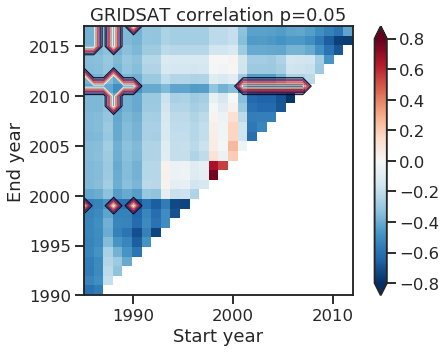

In [295]:
# plot
plt.figure(figsize=(7, 5))
im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.8, vmax=0.8)
plt.contour(start_years, end_years, sig < 0.05, linewidths=1)
plt.colorbar(im, extend='both');
plt.title('GRIDSAT correlation p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()
#plt.savefig('triangle_giss.png', dpi=150)

In [304]:
def monthly(m, d1,d2):

    dg = d1.sel(time=(d1['time.month']==m)).groupby('time.year').mean('time')
    de = d2.sel(time=(d2['time.month']==m)).groupby('time.year').mean('time')
                 
    posgrid = np.intersect1d(dg.year.values, de.year.values)

    de = de.sel(year=posgrid)
    dg = dg.sel(year=posgrid)
                 
    dg = dg.to_pandas()
    de = de.to_pandas()
                 
    # fill the triangle
    trend = np.zeros((ny, ny)) * np.NaN
    sig = np.ones((ny, ny)) 
    for i, start_year in enumerate(start_years):
        for j, end_year in enumerate(end_years):
            data1 = dg.loc[start_year:end_year]
            data2 = de.loc[start_year:end_year]
            if len(data1) < 5:
                continue
            slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
            trend[j, i] = r   # for decadal trends
            sig[j, i] = p_val
    
    return trend, sig

/home/ck/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


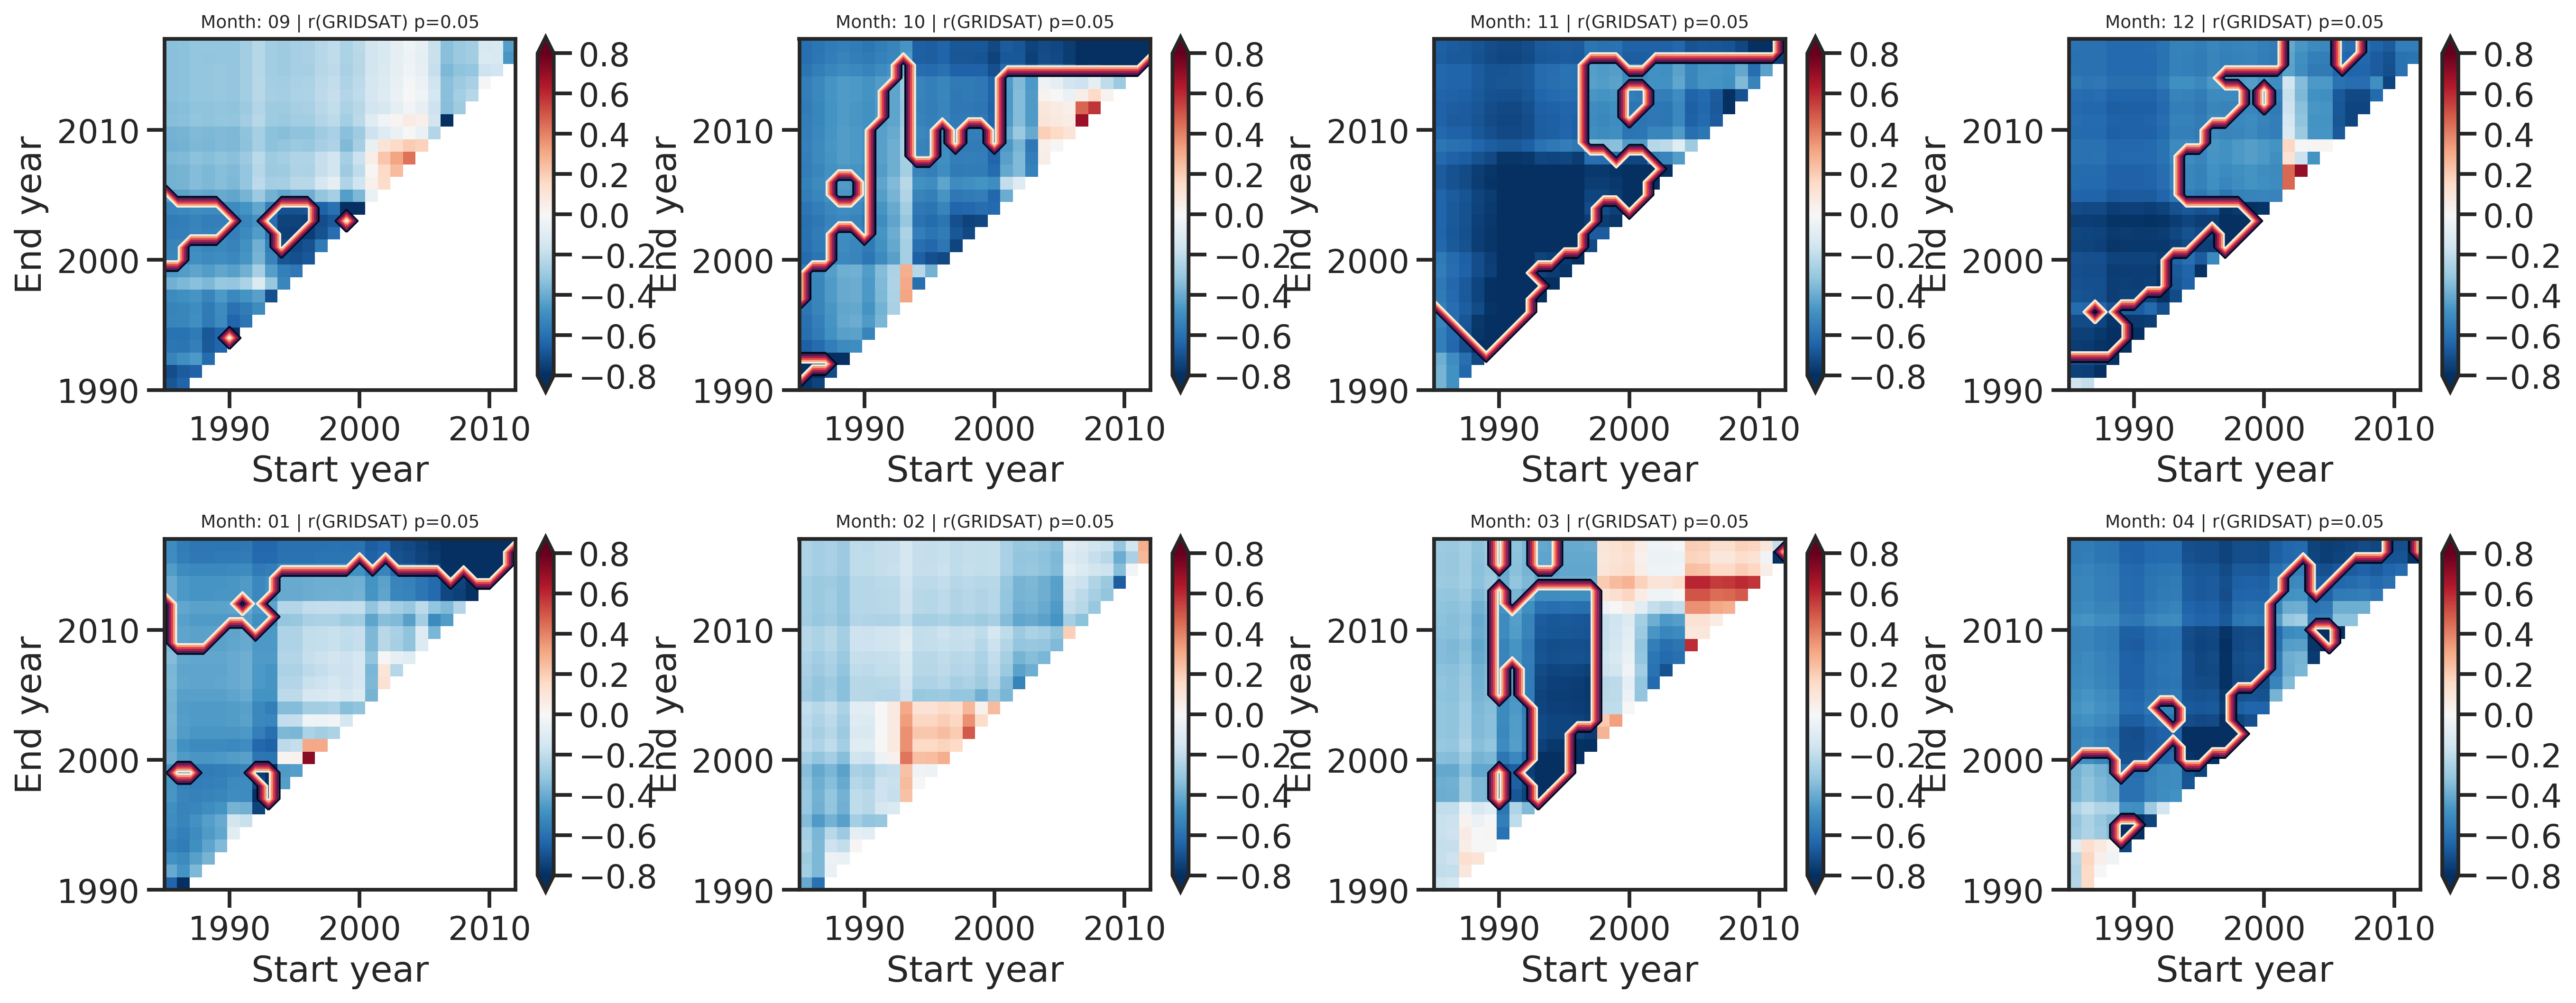

In [307]:
f = plt.figure(figsize=(18,10), dpi=300)
months = [9,10,11,12,1,2,3,4]

for ids, m in enumerate(months): 
    
    trend, sig = monthly(m, era_valley,da3)
    

    ax = f.add_subplot(3,4,ids+1)
        
    im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.8, vmax=0.8)
    plt.contour(start_years, end_years, sig < 0.05, linewidths=1)
    plt.colorbar(im, extend='both');
    plt.title('Month: '+str(m).zfill(2)+' | r(GRIDSAT) p=0.05', fontsize=12);
    plt.xlabel('Start year', fontsize=12);
    plt.ylabel('End year', fontsize=12);

plt.tight_layout()  

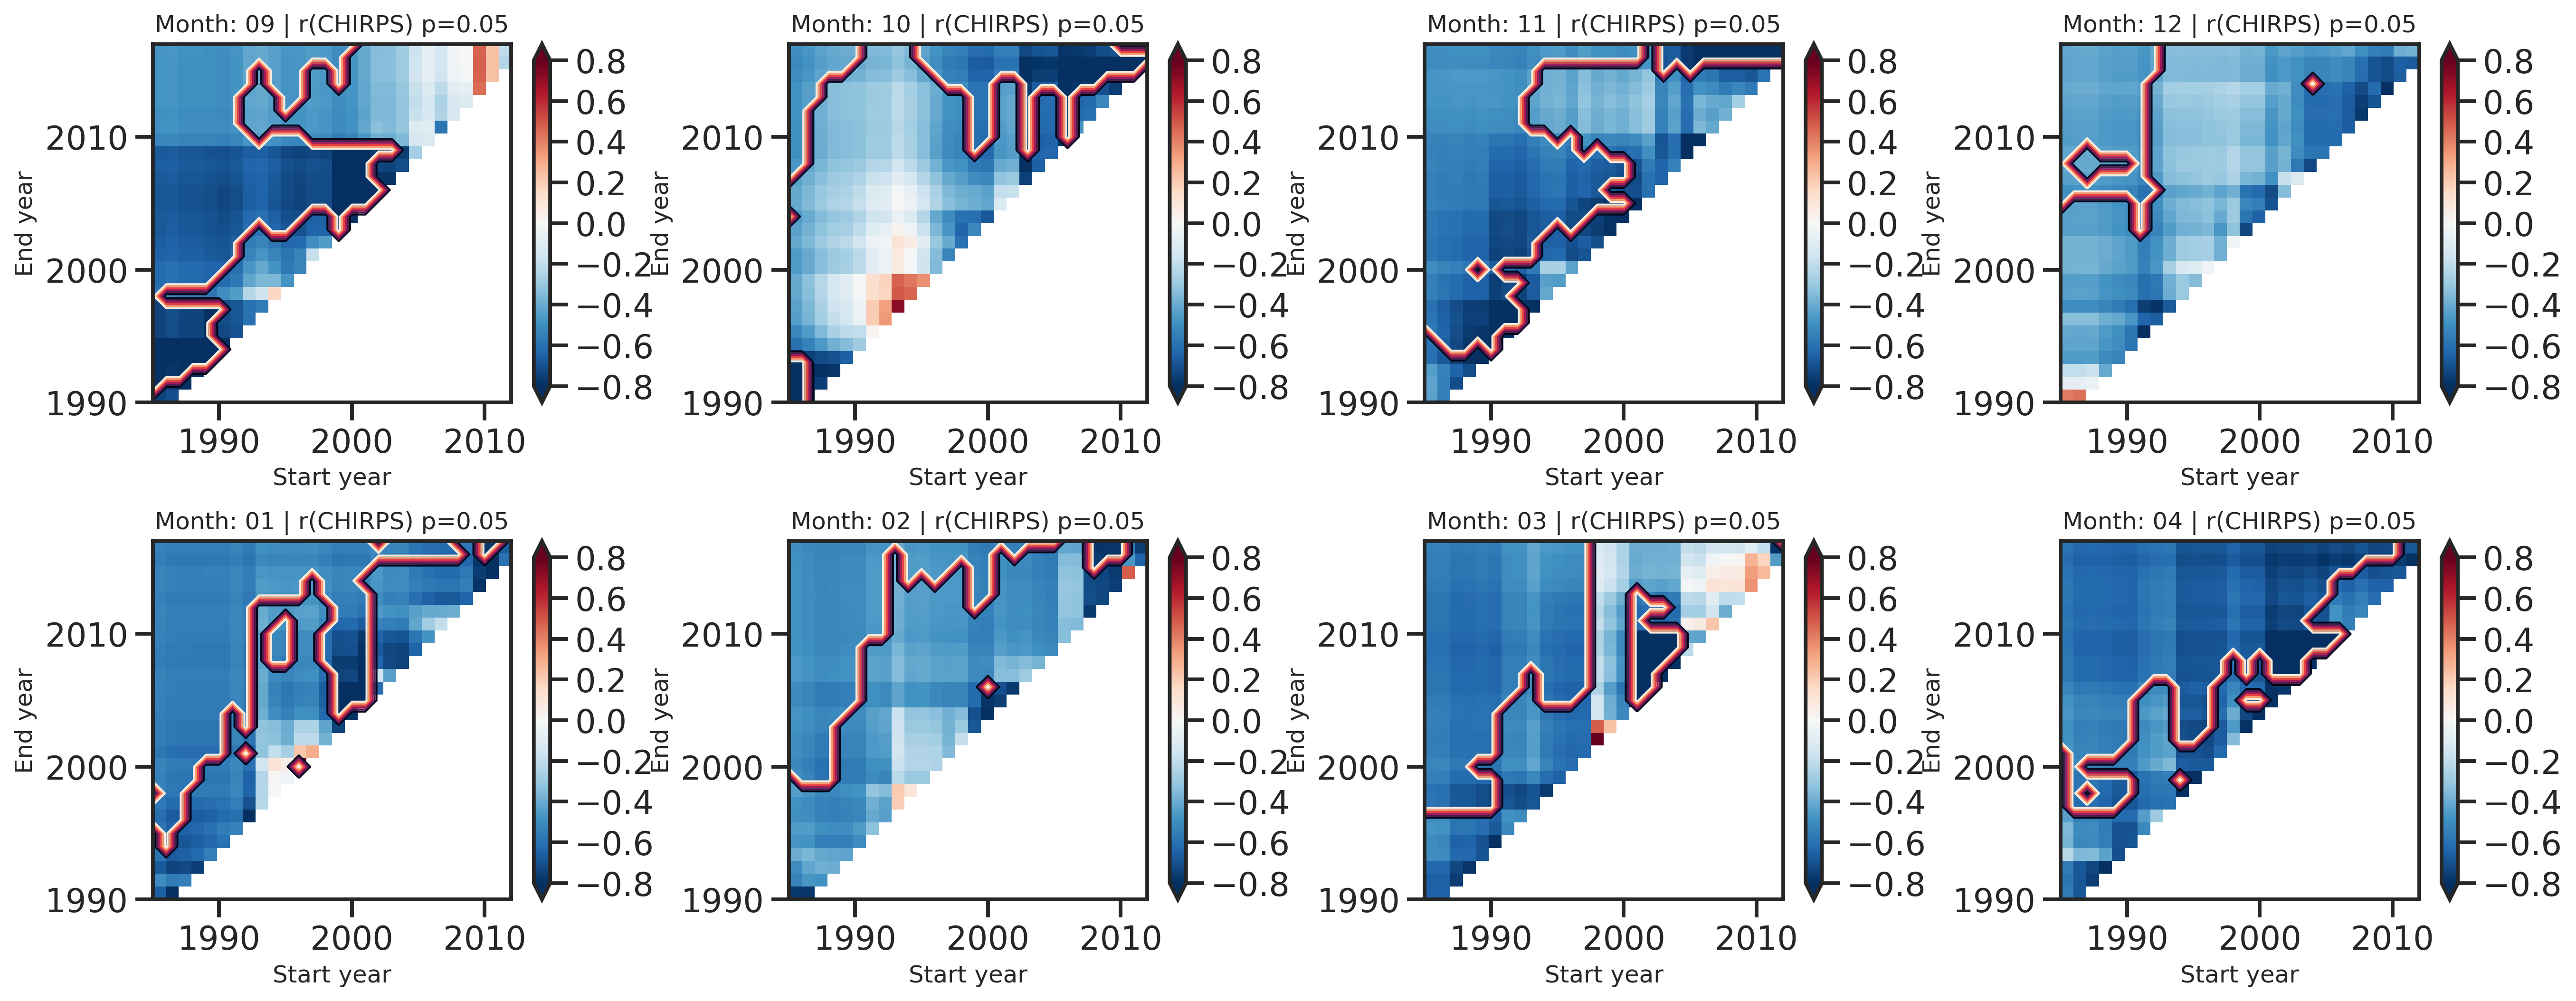

In [309]:
f = plt.figure(figsize=(18,10), dpi=300)
months = [9,10,11,12,1,2,3,4]

for ids, m in enumerate(months): 
    
    trend, sig = monthly(m, era_valley,ca)
    

    ax = f.add_subplot(3,4,ids+1)
        
    im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.8, vmax=0.8)
    plt.contour(start_years, end_years, sig < 0.05, linewidths=1)
    plt.colorbar(im, extend='both');
    plt.title('Month: '+str(m).zfill(2)+' | r(CHIRPS) p=0.05', fontsize=12);
    plt.xlabel('Start year', fontsize=12);
    plt.ylabel('End year', fontsize=12);

plt.tight_layout() 